# Summary Report Utils

This notebooks moves the verbose plotting and interaction routines to a separate notebook to avoid clutter in the final report. It is imported using the `jupyter_cms` extension.

In [1]:
%matplotlib inline

In [2]:
# <api>
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
import collections
from ipywidgets import interact

In [3]:
df = pd.DataFrame({'tags': ['a,b,c', 'd,e,f', 'a,g,h,i', 'a,b,e,f,g'], 'roles_primary': ['x', 'y', 'x', 'y']})

In [4]:
# <api>
def count_tags(tag_series, pct=False):
    '''
    Count comma separated tags.

    :param tag_series: Series of comma separated tag values
    :param pct: If True, compute percentages over number of respondents
    :return: Series with individual tags as index, counts/percentages as values
    '''
    tagged = tag_series.dropna()
    num_respondents = len(tagged)
    
    tag_counts = (tagged.str.split(',')
        .apply(lambda x: pd.value_counts(x))
        .sum(axis=0)
        .sort_values(ascending=False)         
    )
    
    if pct:
        tag_counts = tag_counts.div(num_respondents)
        tag_counts.name = 'Fraction of respondents'
    else:
        tag_counts.name = 'Respondents'
    return tag_counts
pd.Series.count_tags = count_tags

In [5]:
# <help:count_tags>
df

,roles_primary,tags
0,x,"a,b,c"
1,y,"d,e,f"
2,x,"a,g,h,i"
3,y,"a,b,e,f,g"


In [6]:
# <help:count_tags>
df.tags.count_tags()

a    3.0
g    2.0
f    2.0
e    2.0
b    2.0
i    1.0
h    1.0
d    1.0
c    1.0
Name: Respondents, dtype: float64

In [7]:
# <help:count_tags>
df.tags.count_tags(pct=True)

a    0.75
g    0.50
f    0.50
e    0.50
b    0.50
i    0.25
h    0.25
d    0.25
c    0.25
Name: Fraction of respondents, dtype: float64

In [8]:
# <api>
def plot_tags(tag_series, ax=None):
    '''
    Plot tag counts.
    
    :param ax: Axis on which to plot
    :return: Axis
    '''
    new_index = tag_series.reset_index()['index'].str.slice(0, 20)
    tag_series.index = new_index
    ax = tag_series.plot(kind='bar', color='black', ax=ax)
    
    ax.set_xlabel('')
    ax.set_ylabel(tag_series.name)
    ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=25, ha='right')
    return ax
pd.Series.plot_tags = plot_tags

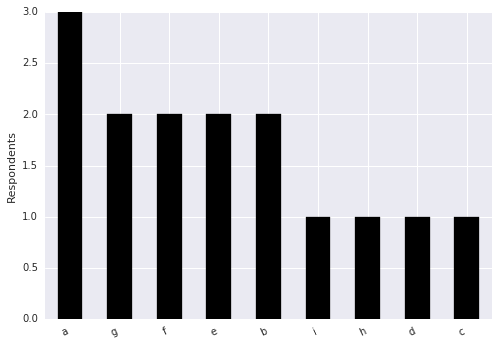

In [9]:
# <help:plot_tags>
df.tags.count_tags().plot_tags()

In [10]:
# <api>
def count_tags_by(tag_series, category_series, pct=False):
    '''
    Count comma separated tags grouped by categories.
    
    :param tag_series: Series of comma separated tag values
    :param category_series: Series of categories by which to group, indexed
      the same as tag_series
    :param pct: If True, Ccompute percentages within each category
    :return: DataFrame with categories as columns, individual tags as index,
      and counts/percentages as values
    '''
    # split tags into columns with 1-value per hit
    tag_counts = (tag_series.dropna()
        .str.split(',')
        .apply(lambda x: pd.Series(1, index=set(x)))
    )

    by = category_series.name
    tag_counts[by] = category_series
    grouped_tag_counts = tag_counts.groupby(by).sum().T
    
    if pct:
        grouped_tag_counts = grouped_tag_counts.div(category_series.value_counts())
        grouped_tag_counts.index.name = 'Fraction of respondents in group'
    else:
        grouped_tag_counts.index.name = 'Respondents'
    
    return (grouped_tag_counts.reindex(
                grouped_tag_counts
                    .sum(axis=1)
                    .sort_values(ascending=False)
                    .index
                )
            )
pd.Series.count_tags_by = count_tags_by

In [11]:
# <help:count_tags_by>
df

,roles_primary,tags
0,x,"a,b,c"
1,y,"d,e,f"
2,x,"a,g,h,i"
3,y,"a,b,e,f,g"


In [12]:
# <help:count_tags_by>
df.tags.count_tags_by(df.roles_primary)

roles_primary,x,y
Respondents,,
a,2.0,1.0
g,1.0,1.0
f,NaN,2.0
e,NaN,2.0
b,1.0,1.0
i,1.0,NaN
h,1.0,NaN
d,NaN,1.0
c,1.0,NaN


In [13]:
# <help:count_tags_by>
df.tags.count_tags_by(df.roles_primary, pct=True)

roles_primary,x,y
Fraction of respondents in group,,
a,1.0,0.5
g,0.5,0.5
f,NaN,1.0
e,NaN,1.0
b,0.5,0.5
i,0.5,NaN
h,0.5,NaN
d,NaN,0.5
c,0.5,NaN


In [14]:
# <api>
def plot_tags_by(grouped_tag_counts, ax=None, order=None):
    '''
    Plot tag counts grouped by category.
    
    :param order: Order of the groups, to help ensure common color assignment across plots 
    :param ax: Axis on which to plot

    :return: Axis
    '''
    if order:
        grouped_tag_counts = grouped_tag_counts.loc[:, order]
    
    # trunacate labels
    new_index = grouped_tag_counts.index.to_series()
    new_index = new_index.str.slice(0, 20)
    # want the truncated series values to be the new index, so assign
    grouped_tag_counts.index = new_index

    ax = grouped_tag_counts.plot(kind='bar', ax=ax)

    ax.set_xlabel('')
    ax.set_ylabel(grouped_tag_counts.index.name)
    ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=25, ha='right')
    
    return ax
pd.DataFrame.plot_tags_by = plot_tags_by

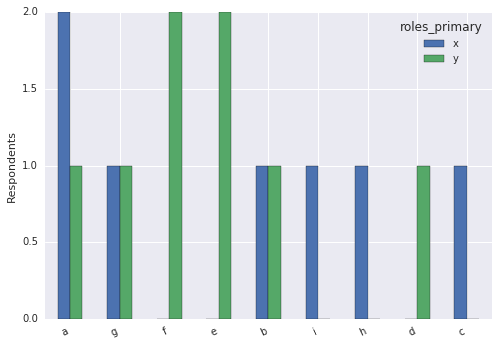

In [15]:
# <help:plot_tags_by>
df.tags.count_tags_by(df.roles_primary).plot_tags_by()

In [16]:
# <api>
group_names = collections.OrderedDict([
    ('-- No grouping --', '-- No grouping --'),
    ('How often do you use Jupyter Notebook?', 'how_often'),
    ('Roughly how long have you been using Jupyter Notebook?', 'how_long_used'),
    ('How many years have you been in this job role?', 'years_in_role'),
    ('How many people typically see and/or interact with the results of your work in Jupyter Notebook?', 'audience_size'),
    ('What is your primary role when using Jupyter Notebook?', 'roles_primary')
])
group_orders = {
    'how_often': ['Daily', 'Weekly', 'Monthly', 'Less often than monthly'],
    'audience_size': ['Tens', 'Hundreds', 'Thousands', 'Tens of thousands', 'Hundreds of thousands or more'],
    'years_in_role': ['5+ years', '2-5 years', '1 year', 'Less than 1 year'],
    'how_long_used': ['One year or more', 'Less than one year'],
    'how_run': ['As a standalone application', 'Through Jupyter Hub', 'Other - Write In']
}
default_labels = ['Keyword patterns', 'Annotator themes']
cutoff = 15

In [17]:
# <api>
def explore(df, series, labels=default_labels):
    '''
    Creates an interactive widget in which the user can:
    
    * Look at response counts and percentages for one of the provided series
    * Group values in the selected series by responses to other questions
    
    :param df: DataFrame containing all of the series and all of the
        possible columns to group by
    :param series: Series to plot
    :param labels: Labels to show for the series
    '''
    @interact(show=labels, 
              group_by=list(group_names.keys()), 
              values=['Counts', 'Percentages'])
    def _explore(show, group_by, values):
        tag_series = series[labels.index(show)]
        percentages = True if values == 'Percentages' else False
            
        group_by = group_names[group_by]
        order = group_orders.get(group_by)

        if group_by == '-- No grouping --':
            ax = tag_series.count_tags(pct=percentages).head(cutoff).plot_tags()
        elif group_by in df.columns:
            ax = tag_series.count_tags_by(df[group_by], pct=percentages).head(cutoff).plot_tags_by(order=order)
        else:
            print('Group by column not found')
            return
        
        ax.set_xlabel('Top {} ({} max)'.format(show.lower(), cutoff))

Note: The test DataFrame in this notebook only has one column to group by `roles_primary` which is tied to the `group_by` value "What is your primary role when using Jupyter Notebook?" below.

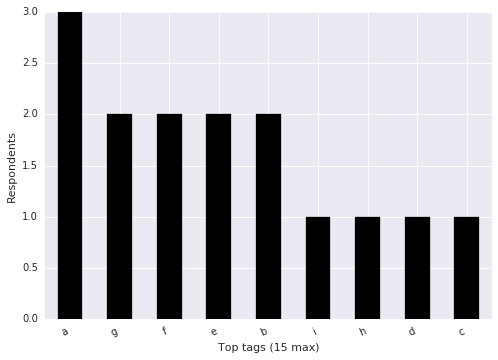

In [18]:
# <help:explore>
explore(df, [df.tags], ['tags'])